In [1]:
import os
os.chdir('/root/evaluate-saliency-4/jigsaw')
from benchmark_utils import AddPath,ChangeDir
from benchmark import settings


# view the saliency

In [2]:
def create_heat_map(ref,patch_theta0,importances_,span,sigma,device,non_lin,masking_mode):
    grid_size = ref.shape[-2:]
    lim_mode = 'full'
    patch_theta = get_patch_theta(patch_theta0,grid_size,span,non_lin = non_lin,lim_mode=lim_mode)
    patch_centers = patch_centers_(patch_theta,grid_size,span)
    patch_masks = create_gaussian_masks(patch_centers,span,sigma,grid_size,device=device)
    patches = extract_masked_patches(ref,patch_masks,patch_centers,
    span,masking_mode=masking_mode)      
    #========================================================
    new_patch_centers = realign_patch_centers_(ref.shape[-2:],patches,patch_centers,span)
    relative_new_patch_centers = get_relative_patch_centers(new_patch_centers,span,ref.shape)     
    importance_patches = [pm * pi for pm,pi in zip(patch_masks,importances_)]
#     heat_map = place_patches_at_locations(ref.shape[-2:],importance_patches,new_patch_centers,span)
    heat_map =  place_patches_at_locations(ref.shape[-2:],importance_patches,
                                           new_patch_centers,
                                           relative_new_patch_centers,
                                           span,check_non_overlap=False,
                                           stitching='mean',
                                           smoothen=False)

    # heat_map = place_patches_at_locations(ref.shape[-2:],patches,new_patch_centers,P.span)
    # heat_map_ = tensor_to_numpy(heat_map)[0,0]
    # return heat_map_
    return heat_map
# plt.figure()
# plt.imshow(heat_map[0,0],cmap='hot')
# plt.show()


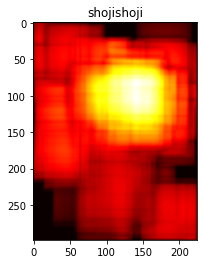

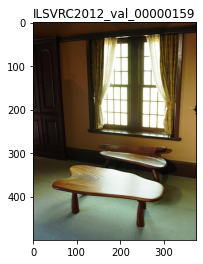

In [10]:
import glob
import pickle
import torch
from cnn import denormalize_vgg
from jigsaw import place_patches_at_locations
from evaluate import realign_patch_centers_
from patch import extract_masked_patches,create_gaussian_masks
from model import get_patch_theta
from model import patch_centers_
from patch import get_relative_patch_centers
from cnn import get_target_id
available_methods = [  
                        # 'gradcam',
                        # 'smoothgrad',
                        # 'fullgrad',
                        # 'integrated-gradients',
                        # 'gradients',
                        # 'inputXgradients',
                        # 'jigsaw-saliency',
                        ]
imagenet_root = '/root/evaluate-saliency-4/jigsaw/imagenet'
# methodname = 'gradcam'
methodname = 'jigsaw-saliency'
modelname = 'vgg16'
has_image_dirs = os.path.join(settings.RESULTS_DIR,f'{methodname}-{modelname}')
image_dirs = list(sorted(glob.glob(os.path.join(has_image_dirs,'*/'))))
ix_of_chosen = 158

chosen_image_dir = image_dirs[ix_of_chosen]
image_root = os.path.basename(chosen_image_dir.rstrip(os.path.sep))
impath = os.path.join(imagenet_root,'images','val',image_root) + '.JPEG'
pklnames = glob.glob(os.path.join(chosen_image_dir,'*.pkl'))
assert len(pklnames) == 1
pklname = list(pklnames)[0]
with open(pklname,'rb') as f:
    loaded = pickle.load(f)
if methodname == 'jigsaw-saliency':
    saliency = loaded['trends']['im_overlayed_importances']
else:
    assert 'saliency' in loaded
    saliency = loaded['saliency']
# else:
#     #==================================================================================
#     device = 'cpu'
#     saliency = create_heat_map(torch.tensor(loaded['ref']).float().to(device),
#                                torch.tensor(loaded['patch_theta0']).float().to(device),
#                                loaded['importances']['importances'],
#                                loaded['parameters']['patch_options']['span'],
#                                loaded['parameters']['patch_options']['sigma'],
#                                device,
#                                loaded['parameters']['non_lin'],
#                                 loaded['parameters']['patch_options']['masking_mode'],
#                               )
    
classname = loaded['classname']
# target_id = loaded['target_id']
target_id = classname
if saliency.ndim == 4:
    saliency = saliency[0]
#-------------------------------------
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(saliency[0],cmap='hot')
plt.title(f'{classname}{target_id}')
plt.show()
#-------------------------------------
import skimage.io
im = skimage.io.imread(impath)
plt.figure()
plt.imshow(im,cmap='hot')
plt.title(f'{image_root}')
plt.show()

In [4]:
# saliency.shape
# !ls /root/evaluate-saliency-4/jigsaw/imagenet/images/val